Load libraries

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

dataset link https://www.quandl.com/data/BOE/XUDLERD-Spot-Exchange-Rate-Euro-Into-Us

In [2]:
df_fx_data=pd.read_csv("exchange_rates.csv")

In [3]:
df_fx_data.shape

(11724, 2)

In [4]:
df_fx_data.head(5)

,Date,Value
0,2021-05-13,0.8282
1,2021-05-12,0.8282
2,2021-05-11,0.8222
3,2021-05-10,0.8223
4,2021-05-07,0.8236


In [5]:
df_fx_data.dtypes

Date      object
Value    float64
dtype: object

In [6]:
df_fx_data.columns

Index(['Date', 'Value'], dtype='object')

In [7]:
df_fx_data.isnull()

,Date,Value
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
11719,False,False
11720,False,False
11721,False,False
11722,False,False


In [8]:
df_fx_data.isnull().sum()

Date     0
Value    0
dtype: int64

In [9]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'], format = '%Y-%m-%d')
indexed_df = df_fx_data.set_index('Date')

In [10]:
ts_euro = indexed_df['Value']
ts_euro.head(5)

Date
2021-05-13    0.8282
2021-05-12    0.8282
2021-05-11    0.8222
2021-05-10    0.8223
2021-05-07    0.8236
Name: Value, dtype: float64

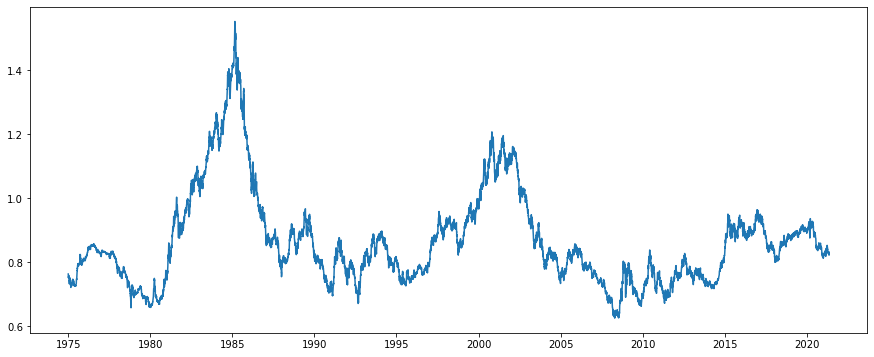

In [11]:
plt.plot(ts_euro.index.to_pydatetime(), ts_euro.values)

In [12]:
ts_euro_week = ts_euro.resample('W').mean()

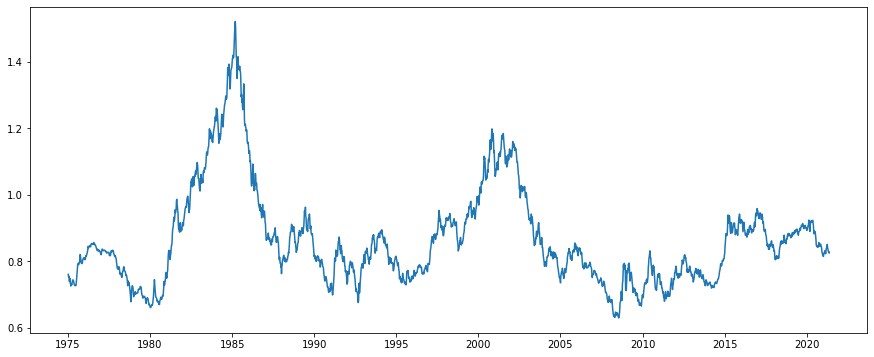

In [13]:
plt.plot(ts_euro_week.index.to_pydatetime(), ts_euro_week.values)

In [14]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

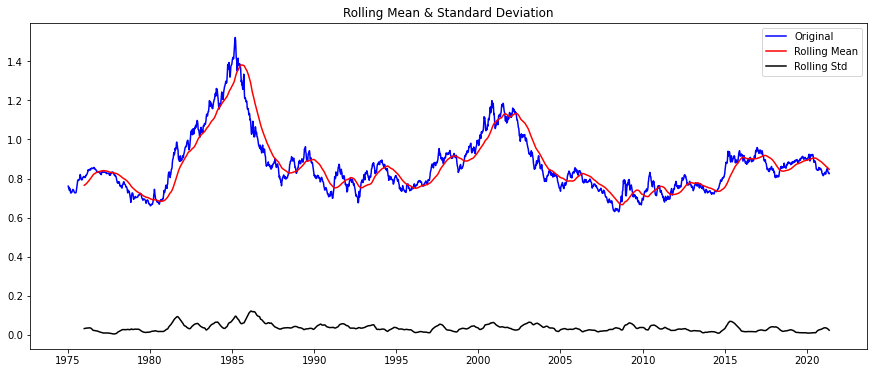

Results of Dickey-Fuller Test:
Test Statistic                   -2.163157
p-value                           0.219888
#Lags Used                        2.000000
Number of Observations Used    2417.000000
Critical Value (1%)              -3.433058
Critical Value (5%)              -2.862737
Critical Value (10%)             -2.567407
dtype: float64


In [15]:
check_stationarity(ts_euro_week)

In [16]:
ts_euro_week_log = np.log(ts_euro_week)

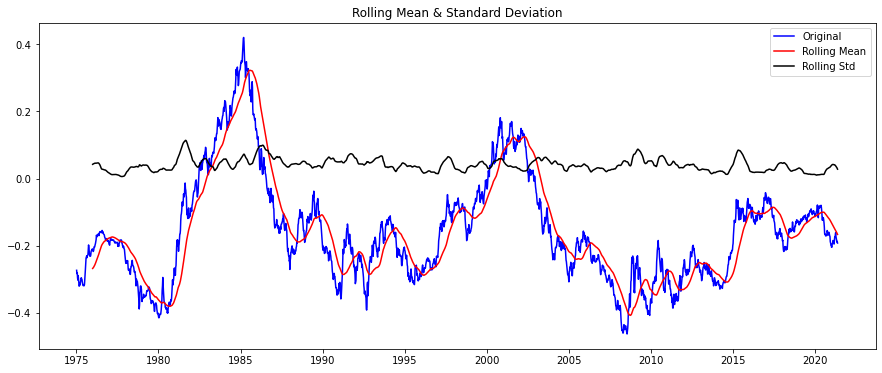

Results of Dickey-Fuller Test:
Test Statistic                   -2.345470
p-value                           0.157722
#Lags Used                        1.000000
Number of Observations Used    2418.000000
Critical Value (1%)              -3.433057
Critical Value (5%)              -2.862736
Critical Value (10%)             -2.567407
dtype: float64


In [17]:
check_stationarity(ts_euro_week_log)

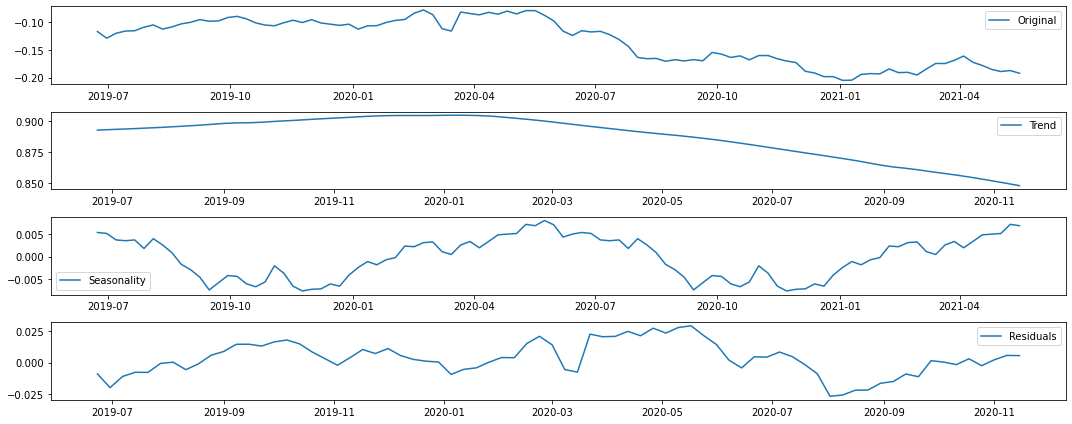

In [18]:
decomposition = seasonal_decompose(ts_euro_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Select the most recent weeks 
ts_euro_week_log_select = ts_euro_week_log[-100:]

plt.subplot(411)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), ts_euro_week_log_select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), trend[-100:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), seasonal[-100:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), residual[-100:].values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

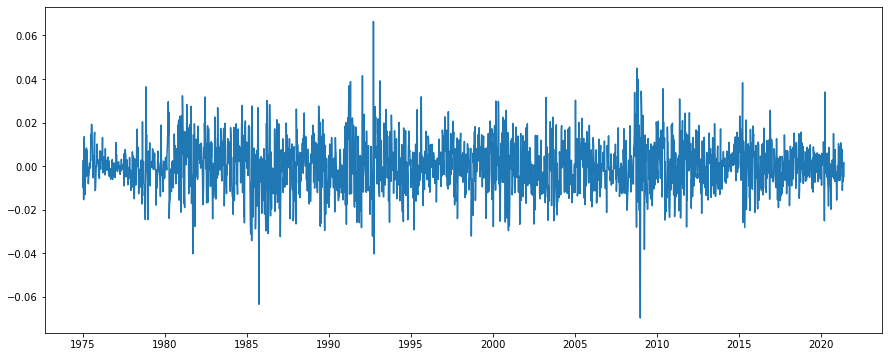

In [19]:
ts_euro_week_log_diff = ts_euro_week_log - ts_euro_week_log.shift()
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), ts_euro_week_log_diff.values)

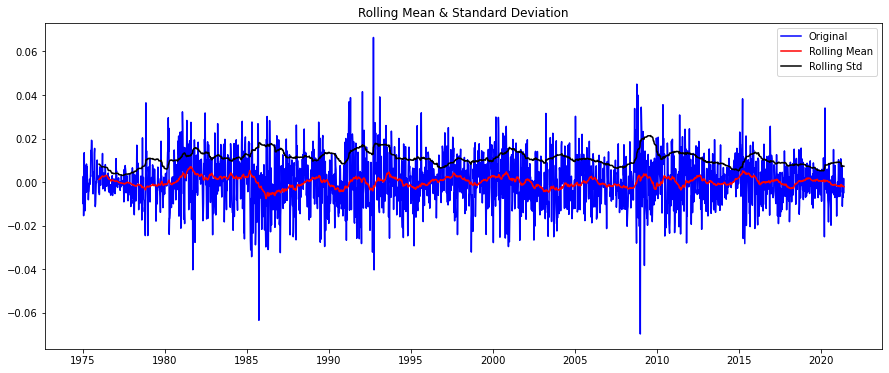

Results of Dickey-Fuller Test:
Test Statistic                  -38.286474
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2418.000000
Critical Value (1%)              -3.433057
Critical Value (5%)              -2.862736
Critical Value (10%)             -2.567407
dtype: float64


In [20]:
ts_euro_week_log_diff.dropna(inplace=True)
check_stationarity(ts_euro_week_log_diff)

C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


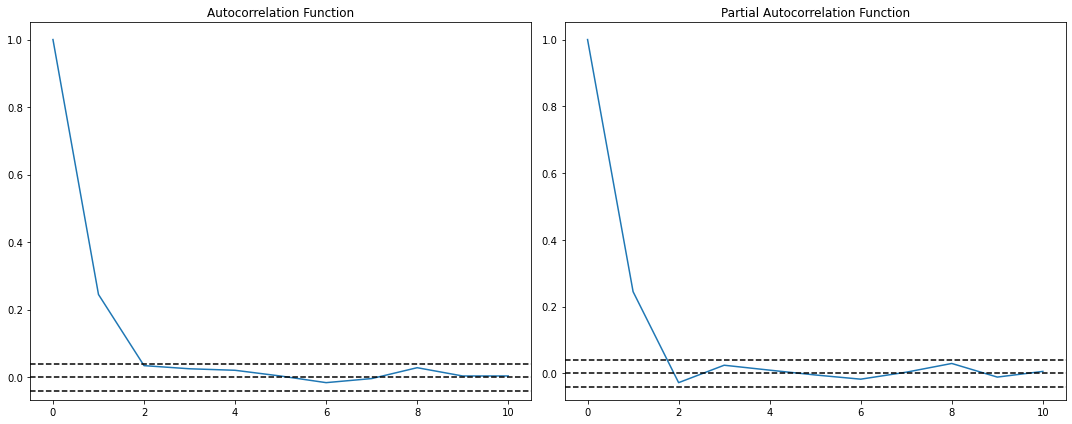

In [21]:
#ACF and PACF plots

lag_auto_corr = acf(ts_euro_week_log_diff, nlags=10)
lag_par_auto_corr = pacf(ts_euro_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_par_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [22]:
model = ARIMA(ts_euro_week_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1) 

C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'RSS: 0.2910')

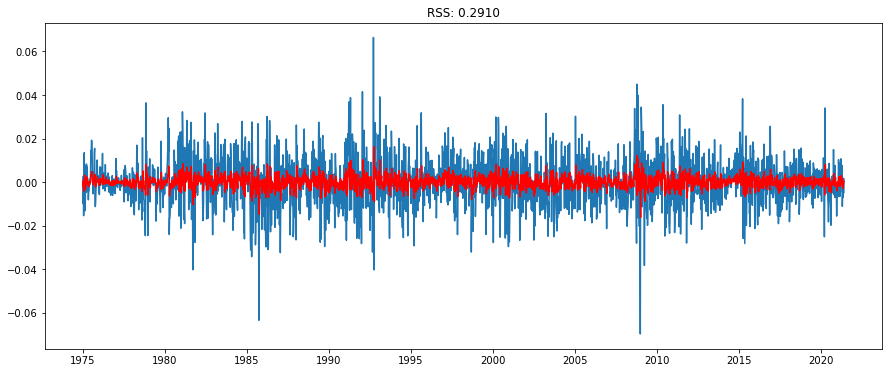

In [23]:
model = ARIMA(ts_euro_week_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), ts_euro_week_log_diff.values)
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_euro_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2419
Model:                 ARIMA(2, 1, 2)   Log Likelihood                7484.055
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 22 May 2021   AIC                         -14956.110
Time:                        14:54:27   BIC                         -14921.363
Sample:                    01-12-1975   HQIC                        -14943.474
                         - 05-16-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.109e-05      0.000      0.104      0.917      -0.001       0.001
ar.L1.D.Value     0.5572      1.165      0.478      0.632      -1.725       2.840
ar.L2.D.Value     0.0180      0.198     

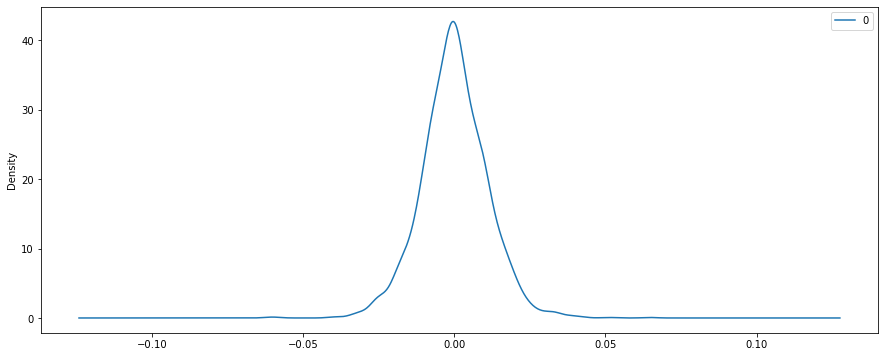

In [24]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [25]:
euro_predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (euro_predictions_ARIMA_diff.head())
print (euro_predictions_ARIMA_diff.tail())

Date
1975-01-12    0.000031
1975-01-19   -0.002384
1975-01-26    0.000957
1975-02-02   -0.004186
1975-02-09   -0.001100
Freq: W-SUN, dtype: float64
Date
2021-04-18   -0.002855
2021-04-25   -0.000848
2021-05-02   -0.001742
2021-05-09   -0.000827
2021-05-16    0.000385
Freq: W-SUN, dtype: float64


In [26]:
euro_predictions_ARIMA_diff_cumsum = euro_predictions_ARIMA_diff.cumsum()
euro_predictions_ARIMA_log = pd.Series(ts_euro_week_log.iloc[0], index=ts_euro_week_log.index)
euro_predictions_ARIMA_log = euro_predictions_ARIMA_log.add(euro_predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5, 1.0, 'RMSE: 0.1323')

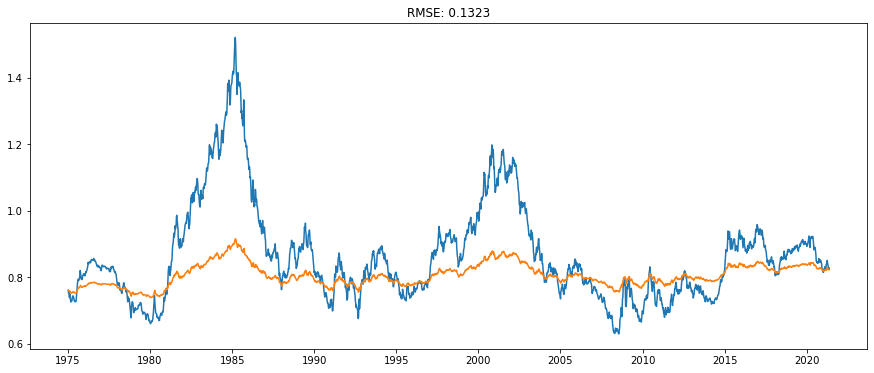

In [27]:
euro_predictions_ARIMA = np.exp(euro_predictions_ARIMA_log)
plt.plot(ts_euro_week.index.to_pydatetime(), ts_euro_week.values)
plt.plot(ts_euro_week.index.to_pydatetime(), euro_predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((euro_predictions_ARIMA-ts_euro_week)**2)/len(ts_euro_week)))

In [28]:
size = int(len(ts_euro_week_log) - 15)
train, test = ts_euro_week_log[0:size], ts_euro_week_log[size:len(ts_euro_week_log)]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Euro Rate = %f, Expected Euro Rate = %f' % (np.exp(yhat), np.exp(observed)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

euro_predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...




C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.e

Predicted Euro Rate = 0.823971, Expected Euro Rate = 0.831620


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.833341, Expected Euro Rate = 0.826140


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between a

Predicted Euro Rate = 0.824349, Expected Euro Rate = 0.826580


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.826828, Expected Euro Rate = 0.822660


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.821482, Expected Euro Rate = 0.831500


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between a

Predicted Euro Rate = 0.833766, Expected Euro Rate = 0.839820


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.841456, Expected Euro Rate = 0.839660


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.839327, Expected Euro Rate = 0.844500


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.845764, Expected Euro Rate = 0.851000


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.852461, Expected Euro Rate = 0.841600


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.839081, Expected Euro Rate = 0.836800


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.836013, Expected Euro Rate = 0.830980


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.829539, Expected Euro Rate = 0.827800


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Euro Rate = 0.827116, Expected Euro Rate = 0.829200
Predicted Euro Rate = 0.829522, Expected Euro Rate = 0.825225


Printing Mean Squared Error of Predictions...
Test MSE: 0.000048


C:\Users\pjpun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


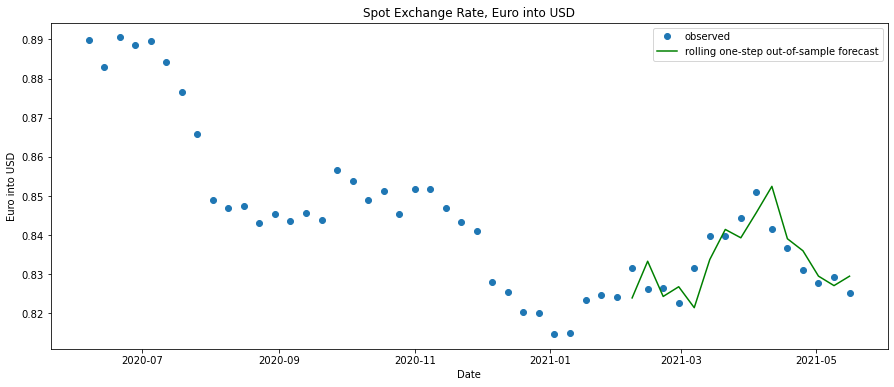

In [29]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_euro_week[-50:], 'o', label='observed')
ax.plot(np.exp(euro_predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper right')
legend.get_frame().set_facecolor('w')